In [1]:
from pathlib import Path
import sys

sys.path.insert(0, str(Path().absolute().parent))

In [2]:
import matplotlib.pyplot as plt
from tensorflow.random import set_seed
from tensorflow.keras import Model, Sequential
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, Poisson
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import ReLU, BatchNormalization, Conv2D, Add, Input, AveragePooling2D, MaxPooling2D, Flatten, Dense, ReLU

In [3]:
from settings import PATH, SETTINGS

In [4]:
set_seed(SETTINGS['random_seed'])
datagen_pars0 = {'width_shift_range': 0.2, 'height_shift_range': 0.2,
                 'shear_range': 0.2, 'zoom_range': 0.2, 'fill_mode': 'reflect',
                 'horizontal_flip': True, 'vertical_flip': True}
# datagen_pars0 = {}
datagen_pars = {'target_size': SETTINGS['image_shape_for_amp_1'], 'batch_size': 16,
                'class_mode': 'sparse', 'seed': SETTINGS['random_seed'],
                'color_mode': 'grayscale'}

train_datagen_flow = ImageDataGenerator(**datagen_pars0).flow_from_directory(PATH['data']['amp_1']['generated'], **datagen_pars)
val_datagen_flow = ImageDataGenerator(**datagen_pars0).flow_from_directory(PATH['data']['amp_1']['train'], **datagen_pars)

Found 690 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


In [12]:
# c_par = {'filters': 6, 'kernel_size': (3, 3)}
c_par = {'kernel_size': (3, 3)}
mp_par = {'pool_size': (3, 3), 'strides': 3}

model = Sequential()
filters = 32
model.add(Conv2D(input_shape=SETTINGS['image_shape_for_amp_1'] + (1, ), filters=filters, **c_par))
filters *= 2
model.add(MaxPooling2D(**mp_par))

model.add(Conv2D(filters=filters, **c_par))
filters *= 2
model.add(MaxPooling2D(**mp_par))

model.add(Conv2D(filters=filters, **c_par))
filters *= 2
model.add(MaxPooling2D(**mp_par))

model.add(Flatten())
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=1e-4), metrics=AUC())
model.compile(loss=BinaryCrossentropy(), optimizer=RMSprop(learning_rate=1e-5), metrics=AUC())

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 138, 3998, 32)     320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 46, 1332, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 44, 1330, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 443, 64)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 441, 128)      73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 4, 147, 128)     

In [7]:
%%time
history = model.fit(train_datagen_flow,
                    validation_data=val_datagen_flow,
                    steps_per_epoch=int(len(train_datagen_flow) / 4),
                    validation_steps=int(len(val_datagen_flow) / 10),
                    epochs=10)

Epoch 1/15
11/11 [==============================] - 24s 2s/step - loss: 1089.3914 - auc: 0.4952 - val_loss: 748.2188 - val_auc: 0.4792
Epoch 2/15
11/11 [==============================] - 22s 2s/step - loss: 762.9700 - auc: 0.4861 - val_loss: 707.1799 - val_auc: 0.4499
Epoch 3/15
11/11 [==============================] - 24s 2s/step - loss: 659.8190 - auc: 0.4727 - val_loss: 454.8008 - val_auc: 0.5907
Epoch 4/15
11/11 [==============================] - 21s 2s/step - loss: 723.5008 - auc: 0.4610 - val_loss: 474.3408 - val_auc: 0.5125
Epoch 5/15
11/11 [==============================] - 23s 2s/step - loss: 578.3735 - auc: 0.5183 - val_loss: 772.7263 - val_auc: 0.4976
Epoch 6/15
11/11 [==============================] - 24s 2s/step - loss: 559.6436 - auc: 0.5744 - val_loss: 564.9767 - val_auc: 0.4350
Epoch 7/15
11/11 [==============================] - 23s 2s/step - loss: 550.5369 - auc: 0.5231 - val_loss: 614.6617 - val_auc: 0.4219
Epoch 8/15
11/11 [==============================] - 23s 2s/st

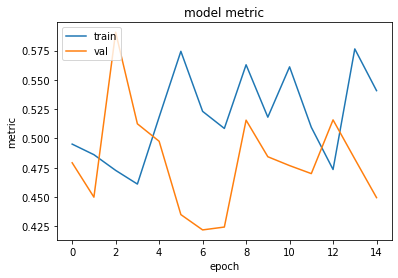

In [8]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model metric')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

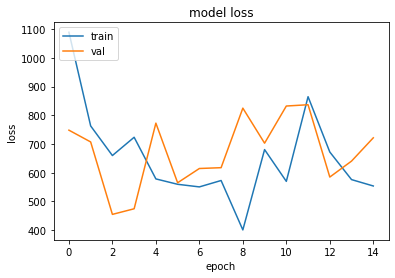

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()